In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

def beam_generator_G1(
    bunch1_charge_pC,
    bunch1_sigma_um,
    windowsize=1024,
    resolution_um=0.1
):
    """
    Generate a 1D beam profile consisting of 1 Gaussian bunch.

    """

    # x-axis
    x_um = np.arange(windowsize) * resolution_um

    # choose center positions
    center1 = windowsize * resolution_um / 2

    # two Gaussian bunches
    g1 = bunch1_charge_pC * np.exp(-(x_um - center1) ** 2 / (2 * bunch1_sigma_um ** 2)) / bunch1_sigma_um

    y = g1 
    return x_um, y

def beam_generator_G2(
    bunch1_charge_pC,
    bunch1_sigma_um,
    bunch2_charge_pC,
    bunch2_sigma_um,
    distance_um,
    windowsize=1024,
    resolution_um=0.1
):
    """
    Generate a 1D beam profile consisting of two separated Gaussian bunches.

    Parameters:
        bunch1_charge_pC  : charge of bunch 1   (pC)
        bunch1_sigma_um   : sigma of bunch 1    (um)
        bunch2_charge_pC  : charge of bunch 2   (pC)
        bunch2_sigma_um   : sigma of bunch 2    (um)
        distance_um       : separation between two bunch centers (um)
        windowsize        : length of output array
        resolution_um     : spatial resolution of each sample

    Returns:
        x_um: spatial axis (um)
        y: beam profile array of length `windowsize`
    """

    # x-axis
    x_um = np.arange(windowsize) * resolution_um

    # choose center positions
    center1 = windowsize * resolution_um / 2 - distance_um / 2
    center2 = windowsize * resolution_um / 2 + distance_um / 2

    # two Gaussian bunches
    g1 = bunch1_charge_pC * np.exp(-(x_um - center1) ** 2 / (2 * bunch1_sigma_um ** 2)) / bunch1_sigma_um
    g2 = bunch2_charge_pC * np.exp(-(x_um - center2) ** 2 / (2 * bunch2_sigma_um ** 2)) / bunch2_sigma_um

    y = g1 + g2
    return x_um, y



def beam_generator_G3(
    bunch1_charge_pC,
    bunch1_sigma_um,
    bunch2_charge_pC,
    bunch2_sigma_um,
    distance_um,
    windowsize=1024,
    resolution_um=0.1
):
    """
    Generate a 1D beam profile consisting of three separated Gaussian bunches.

    """

    # x-axis
    x_um = np.arange(windowsize) * resolution_um

    # choose center positions
    center1 = windowsize * resolution_um / 2 - distance_um / 2
    center2 = windowsize * resolution_um / 2 + distance_um / 2

    intervals = [
    (10, center1 - 10),
    (center1 + 5, center2 - 5),
    (center2 + 5, windowsize * resolution_um - 10)
    ]

    
    valid_intervals = []
    lengths = []
    for a, b in intervals:
        if a < b: 
            valid_intervals.append((a, b))
            lengths.append(b - a)

    if valid_intervals:
        total_length = sum(lengths)
        probs = [l / total_length for l in lengths]
        chosen_idx = np.random.choice(len(valid_intervals), p=probs)
        low, high = valid_intervals[chosen_idx]
        center3 = np.random.uniform(low, high)
    else:
        center3 = np.random.uniform(10, windowsize * resolution_um - 10)


    # three Gaussian bunches
    g1 = bunch1_charge_pC * np.exp(-(x_um - center1) ** 2 / (2 * bunch1_sigma_um ** 2)) / bunch1_sigma_um
    g2 = bunch2_charge_pC * np.exp(-(x_um - center2) ** 2 / (2 * bunch2_sigma_um ** 2)) / bunch2_sigma_um

    bunch3_charge_pC = bunch1_charge_pC / np.exp(np.random.uniform(np.log(5), np.log(10)))
    # bunch3_charge_pC = np.exp(np.random.uniform(np.log(100), np.log(min(bunch1_charge_pC, bunch2_charge_pC))))
    bunch3_sigma_um = np.exp(np.random.uniform(np.log(1), np.log(min(bunch1_sigma_um, bunch2_sigma_um))))
    g3 = bunch3_charge_pC * np.exp(-(x_um - center3) ** 2 / (2 * bunch3_sigma_um ** 2)) / bunch3_sigma_um

    y = g1 + g2 + g3
    return x_um, y


In [2]:
def generate_G1L_pt_dataset(
    n,
    range_charge,
    range_sigma,
    save_dir,
    windowsize=1024,
    resolution=0.1
):

    os.makedirs(save_dir, exist_ok=True)
    rs_min, rs_max = range_sigma


    for i in range(n):

        b1_charge = np.random.uniform(*range_charge)

        v = np.random.uniform(np.log(rs_min), np.log(rs_max))
        b1_sigma = np.exp(v)

        x_um, y = beam_generator_G1(
            b1_charge, b1_sigma,
            windowsize,
            resolution
        )

        # x_um = np.round(x_um, 5)
        # y    = np.round(y,    5)

        x_tensor = torch.tensor(x_um, dtype=torch.float32)
        y_tensor = torch.tensor(y,    dtype=torch.float32)

        sample = {
            "x_um": x_tensor,
            "Intensity": y_tensor,
            "b1_charge": float(np.round(b1_charge, 5)),
            "b1_sigma":  float(np.round(b1_sigma, 5)),
        }

        filename = (
            f"G1L_pt_{i+1}_"
            f"Q1_{sample['b1_charge']}_s1_{sample['b1_sigma']}.pt"
        )

        filepath = os.path.join(save_dir, filename)
        torch.save(sample, filepath)

        # print(f"[Saved] {filepath}")

    print("\nDataset (.pt) generation completed with log-uniform!")

In [3]:
def generate_G2RPL_pt_dataset(
    n,
    range_charge,
    range_sigma,
    range_distance,
    ratio_range_charge,          # (r_min, r_max) 
    save_dir,
    windowsize=1024,
    resolution=0.1
):
    """
    Generate n random G2 beam arrays and save each sample as a .pt file.
    - Q1 >= Q2 by construction
    - ratio = Q1 / Q2 is log-uniform
    - values rounded to 5 decimals
    """

    os.makedirs(save_dir, exist_ok=True)
    rc_min, rc_max = ratio_range_charge
    rs_min, rs_max = range_sigma


    for i in range(n):

        # --- 1) Random parameters ---
        b1_charge = np.random.uniform(*range_charge)

        u = np.random.uniform(np.log(rc_min), np.log(rc_max))
        ratio_c = np.exp(u)                  # log-uniform ratio
        b2_charge = b1_charge / ratio_c      # ensure b1 >= b2

        v = np.random.uniform(np.log(rs_min), np.log(rs_max))
        b1_sigma = np.exp(v)
        w = np.random.uniform(np.log(rs_min), np.log(rs_max))
        b2_sigma = np.exp(w)

        distance = np.random.uniform(*range_distance)

        # --- 2) Generate beam ---
        x_um, y = beam_generator_G2(
            b1_charge, b1_sigma,
            b2_charge, b2_sigma,
            distance,
            windowsize,
            resolution
        )

        # --- 3) 保留 5 位小数 ---
        # x_um = np.round(x_um, 5)
        # y    = np.round(y,    5)

        # --- 4) 转为 tensor ---
        x_tensor = torch.tensor(x_um, dtype=torch.float32)
        y_tensor = torch.tensor(y,    dtype=torch.float32)

        # --- 5) 保存为 .pt ---
        sample = {
            "x_um": x_tensor,
            "Intensity": y_tensor,
            "b1_charge": float(np.round(b1_charge, 5)),
            "b2_charge": float(np.round(b2_charge, 5)),
            "b1_sigma":  float(np.round(b1_sigma, 5)),
            "b2_sigma":  float(np.round(b2_sigma, 5)),
            "ratio_c":   float(np.round(ratio_c, 5)),
            "distance":  float(np.round(distance, 5)),
        }

        filename = (
            f"G2RPL_pt_{i+1}_"
            f"Q1_{sample['b1_charge']}_s1_{sample['b1_sigma']}_"
            f"Q2_{sample['b2_charge']}_s2_{sample['b2_sigma']}_"
            f"r_{sample['ratio_c']}_d_{sample['distance']}.pt"
        )

        filepath = os.path.join(save_dir, filename)
        torch.save(sample, filepath)

        # print(f"[Saved] {filepath}")

    print("\nDataset (.pt) generation completed with log-uniform!")

In [4]:
def generate_G3RPL_pt_dataset(
    n,
    range_charge,
    range_sigma,
    range_distance,
    ratio_range_charge,
    save_dir,
    windowsize=1024,
    resolution=0.1
):
    """
    Generate n random G3 beam arrays and save each sample as a .pt file.
    - Q1 >= Q2 by construction
    - ratio = Q1 / Q2 is log-uniform
    - values rounded to 5 decimals
    """

    os.makedirs(save_dir, exist_ok=True)
    rc_min, rc_max = ratio_range_charge
    rs_min, rs_max = range_sigma


    for i in range(n):

        # --- 1) Random parameters ---
        b1_charge = np.random.uniform(*range_charge)

        u = np.random.uniform(np.log(rc_min), np.log(rc_max))
        ratio_c = np.exp(u)                  # log-uniform ratio
        b2_charge = b1_charge / ratio_c      # ensure b1 >= b2

        v = np.random.uniform(np.log(rs_min), np.log(rs_max))
        b1_sigma = np.exp(v)
        w = np.random.uniform(np.log(rs_min), np.log(rs_max))
        b2_sigma = np.exp(w)

        distance = np.random.uniform(*range_distance)

        # --- 2) Generate beam ---
        x_um, y = beam_generator_G3(
            b1_charge, b1_sigma,
            b2_charge, b2_sigma,
            distance,
            windowsize,
            resolution
        )

        # --- 3) 保留 5 位小数 ---
        # x_um = np.round(x_um, 5)
        # y    = np.round(y,    5)

        # --- 4) 转为 tensor ---
        x_tensor = torch.tensor(x_um, dtype=torch.float32)
        y_tensor = torch.tensor(y,    dtype=torch.float32)

        # --- 5) 保存为 .pt ---
        sample = {
            "x_um": x_tensor,
            "Intensity": y_tensor,
            "b1_charge": float(np.round(b1_charge, 5)),
            "b2_charge": float(np.round(b2_charge, 5)),
            "b1_sigma":  float(np.round(b1_sigma, 5)),
            "b2_sigma":  float(np.round(b2_sigma, 5)),
            "ratio_c":   float(np.round(ratio_c, 5)),
            "distance":  float(np.round(distance, 5)),
        }

        filename = (
            f"G3RPL_pt_{i+1}_"
            f"Q1_{sample['b1_charge']}_s1_{sample['b1_sigma']}_"
            f"Q2_{sample['b2_charge']}_s2_{sample['b2_sigma']}_"
            f"r_{sample['ratio_c']}_d_{sample['distance']}.pt"
        )

        filepath = os.path.join(save_dir, filename)
        torch.save(sample, filepath)

        # print(f"[Saved] {filepath}")

    print("\nDataset (.pt) generation completed with log-uniform!")

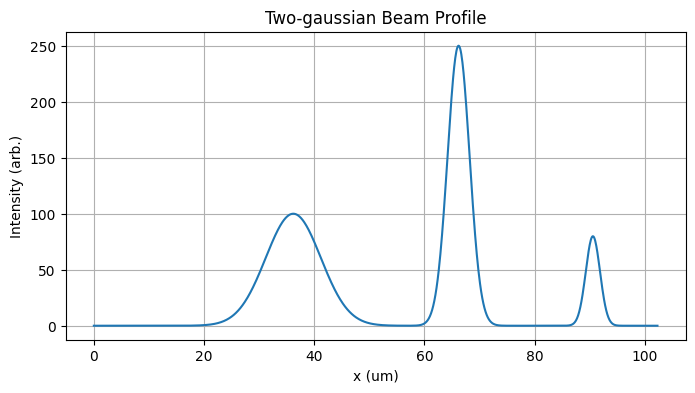

In [5]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# G2 example
bunch1_charge = 500.0    # pC
bunch1_sigma  = 5.0    # um

bunch2_charge = 500.0    # pC
bunch2_sigma  = 2.0    # um

distance      = 30.0   # um

windowsize   = 1024
resolution   = 0.1     # um
# =================================


# 生成数据
x_um, y = beam_generator_G3(
    bunch1_charge,
    bunch1_sigma,
    bunch2_charge,
    bunch2_sigma,
    distance,
    windowsize,
    resolution
)


plt.figure(figsize=(8,4))
plt.plot(x_um, y)
plt.xlabel("x (um)")
plt.ylabel("Intensity (arb.)")
plt.title("Two-gaussian Beam Profile")
plt.grid(True)
plt.show()

# y


In [9]:
# ==== parameters ====
range_charge   = (200, 1000)   # pC
range_sigma  = (1, 5)          # um
range_distance = (10, 50)      # um
ratio_range_charge = (1, 5)
n = 10000
save_dir = "./generated_beam_profile/G1L_200_1000_1_5_10000" 
# =================================

generate_G1L_pt_dataset(
    n=n,
    range_charge=range_charge,
    range_sigma=range_sigma,
    # range_distance=range_distance,
    # ratio_range_charge=ratio_range_charge,
    save_dir=save_dir,
    windowsize=256,
    resolution=0.4
)



Dataset (.pt) generation completed with log-uniform!
